# 💡 SUPPLY / DEMAND INDICATOR

## 📌 Overview
This notebook link the two previously processed - supply (JOCAS) and demand (STMT) for the year 2020 - dataset in order to build a simple indicator of tension at the commune level (most granular possible). 

In [150]:
# ---------------------------------------------------
# Import necessary libraries
# ---------------------------------------------------

# System libraries
import jenkspy
import importlib, subprocess, sys, os, re
from pathlib import Path

# If already installed --> import, if not --> install packages
packages = {
    'pandas': 'pd',
    'numpy': 'np',
    'matplotlib.pyplot': 'plt',
    'unidecode': 'unidecode',
    'geopandas': 'gpd',
    'contextily': 'ctx',
    'matplotlib.colors': 'mcolors',
    'matplotlib.patches': 'mpatches'
}
for mod, alias in packages.items():
    try:
        globals()[alias] = importlib.import_module(mod)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", mod.split('.')[0]])
        globals()[alias] = importlib.import_module(mod)
        

In [151]:
# ---------------------------------------------------
# Define the project's root directory
# ---------------------------------------------------
# Get the current working directory and assume that the project root is one level above.
project_root = Path().resolve().parent

# ---------------------------------------------------
# Construct file paths for each dataset
# ---------------------------------------------------
stmt_file = project_root / "data" / "2- Formatted Data" / "stmt_demand_processed.csv"
jocas_file = project_root / "data" / "2- Formatted Data" / "jocas_offers_processed.csv"
shapefile = project_root / "data" / "shapefiles" / "Zones d'Emploi" / "ze2020_2022.shp"
comm_to_ze_file = project_root / "data" / "linking tables" / "Communes_to_ZE_2022.xlsx"
rome_fap_file = project_root / "data" / "linking tables" / "Rome_to_Fap_processed.csv"
departement_file = project_root / "data" / "linking tables" / "departements-francais.xlsx"

# ---------------------------------------------------
# Import data from files
# ---------------------------------------------------
stmt = pd.read_csv(stmt_file)
jocas = pd.read_csv(jocas_file)
ze_shp = gpd.read_file(shapefile)
comm_to_ze = pd.read_excel(comm_to_ze_file, sheet_name=1, skiprows=5)
rome_fap = pd.read_csv(rome_fap_file)
departement = pd.read_excel(departement_file, skiprows=2)

# ---------------------------------------------------
# Specify the output file path
# ---------------------------------------------------
output_path = project_root / "data" / "3- Final Data" / "ratio_supply_demand.csv"


## 1- WORKFLOW

In [152]:
# ---------------------------------------------------
# MERGE JOB OFFERS AND DEMAND DATA
# ---------------------------------------------------
df = jocas.merge(stmt, on=["commune", "fap87", "month"], how="outer")

# ---------------------------------------------------
# PROCESS COMMUNES TO ZONE-D'EMPLOI DATA
# ---------------------------------------------------
# Rename columns for clarity
comm_to_ze.rename(columns={"LIBGEO": "commune", "LIBZE2020": "zone_emploi"}, inplace=True)

# Standardize commune names: remove accents, convert to lowercase, replace hyphens/apostrophes, and normalize "St." to "saint"
def standardize_commune(name):
    if pd.isna(name):
        return None
    name = unidecode.unidecode(name.lower().strip())
    name = re.sub(r"[-'’]", " ", name)
    name = re.sub(r"\bst[ .]", "saint ", name)
    return name

comm_to_ze["commune"] = comm_to_ze["commune"].apply(standardize_commune)

# Merge the standardized communes data
df = df.merge(comm_to_ze, on="commune", how="left")

# ---------------------------------------------------
# AGGREGATE DATA BY ZONE D'EMPLOI, FAPs, AND MONTH
# ---------------------------------------------------

# Aggregate to FAP87 level
df = df.groupby(["zone_emploi", "fap22", "fap87", "month"], as_index=False).agg(
    job_offers=("job_offers_fap87", "sum"),
    jobseekers_a=("jobseeker_a", "sum"),
    jobseekers_abc=("jobseeker_abc", "sum"),
    departement=("DEP", "first"),
    region=("REG", "first")
)
# ---------------------------------------------------
# MAP DEPARTEMENT AND REGION NAMES
# ---------------------------------------------------
# Ensure that the initial dep/reg code are strings
df["departement"] = df["departement"].astype(str)
df["region"] = df["region"].astype(str)

# Ensure department numbers are two digits
departement["Département\nNuméro"] = departement["Département\nNuméro"].astype(str).str.zfill(2)
dept_mapping = departement.set_index("Département\nNuméro")["Département\nNom"].to_dict()
df["departement"] = df["departement"].map(dept_mapping)

reg_mapping = departement.set_index("Département\nNom")["Région"].to_dict()
df["region"] = df["departement"].map(reg_mapping)

# ---------------------------------------------------
# PRE-PROCESS DATA AND HANDLE ZEROS
# ---------------------------------------------------
df["job_offers"] = pd.to_numeric(df["job_offers"], errors="coerce").fillna(0).astype(int)
df["jobseekers_a"] = pd.to_numeric(df["jobseekers_a"], errors="coerce").fillna(0).astype(int)
df["jobseekers_abc"] = pd.to_numeric(df["jobseekers_abc"], errors="coerce").fillna(0).astype(int)

# Merge fap87 family information
df = df.merge(rome_fap[["fap22", "famille_pro22", "fap87", "famille_pro87"]], on=["fap22", "fap87"], how="left") 

# Adjust zeros to avoid division issues. 
df["job_offers"] = np.where(df["job_offers"] == 0, 0, df["job_offers"])
df["jobseekers_a"] = np.where(df["jobseekers_a"] == 0, 1, df["jobseekers_a"])
df["jobseekers_abc"] = np.where(df["jobseekers_abc"] == 0, 1, df["jobseekers_abc"]) #AQUI

df.head()

,zone_emploi,fap22,fap87,month,job_offers,jobseekers_a,jobseekers_abc,departement,region,famille_pro22,famille_pro87
0,Abbeville,A,A0Z,April,3,10,10,Somme,Hauts-de-France,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons"
1,Abbeville,A,A0Z,April,3,10,10,Somme,Hauts-de-France,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons"
2,Abbeville,A,A0Z,April,3,10,10,Somme,Hauts-de-France,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons"
3,Abbeville,A,A0Z,April,3,10,10,Somme,Hauts-de-France,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons"
4,Abbeville,A,A0Z,April,3,10,10,Somme,Hauts-de-France,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons"


In [153]:
# ---------------------------------------------------
# COMPUTE RATIOS FOR FAP87
# ---------------------------------------------------
df["ratio_a_fap87"] = df["job_offers"] / df["jobseekers_a"]
df["ratio_abc_fap87"] = df["job_offers"] / df["jobseekers_abc"]

# Z-scores
mean_87_a = df["ratio_a_fap87"].mean()
std_87_a = df["ratio_a_fap87"].std()
mean_87_abc = df["ratio_abc_fap87"].mean()
std_87_abc = df["ratio_abc_fap87"].std()

df["ratio_zscore_a_fap87"] = (df["ratio_a_fap87"] - mean_87_a) / std_87_a
df["ratio_zscore_abc_fap87"] = (df["ratio_abc_fap87"] - mean_87_abc) / std_87_abc

# ---------------------------------------------------
# COMPUTE RATIOS FOR FAP22
# ---------------------------------------------------
# 1. Aggregate to fap22 level
df_fap22 = df.groupby(["zone_emploi", "fap22", "month"], as_index=False).agg(
    job_offers_fap22=("job_offers", "sum"),
    jobseekers_a_fap22=("jobseekers_a", "sum"),
    jobseekers_abc_fap22=("jobseekers_abc", "sum")
)

# 2. Compute ratios
df_fap22["ratio_a_fap22"] = df_fap22["job_offers_fap22"] / df_fap22["jobseekers_a_fap22"]
df_fap22["ratio_abc_fap22"] = df_fap22["job_offers_fap22"] / df_fap22["jobseekers_abc_fap22"]

# 3. Z-scores
mean_22_a = df_fap22["ratio_a_fap22"].mean()
std_22_a = df_fap22["ratio_a_fap22"].std()
mean_22_abc = df_fap22["ratio_abc_fap22"].mean()
std_22_abc = df_fap22["ratio_abc_fap22"].std()

df_fap22["ratio_zscore_a_fap22"] = (df_fap22["ratio_a_fap22"] - mean_22_a) / std_22_a
df_fap22["ratio_zscore_abc_fap22"] = (df_fap22["ratio_abc_fap22"] - mean_22_abc) / std_22_abc

# 4. Merge back to original df
df = df.merge(
    df_fap22[["zone_emploi", "fap22", "month", "ratio_a_fap22", "ratio_abc_fap22", 
              "ratio_zscore_a_fap22", "ratio_zscore_abc_fap22"]],
    on=["zone_emploi", "fap22", "month"],
    how="left"
)

# ---------------------------------------------------
# YEARLY MEANS FOR QUINTILES & NATURAL BREAKS — FAP87
# ---------------------------------------------------
df["ymean_ratio_a_fap87"] = df.groupby(["zone_emploi", "fap87"])["ratio_a_fap87"].transform("mean")
df["ymean_ratio_abc_fap87"] = df.groupby(["zone_emploi", "fap87"])["ratio_abc_fap87"].transform("mean")
df["ymean_zscore_a_fap87"] = df.groupby(["zone_emploi", "fap87"])["ratio_zscore_a_fap87"].transform("mean")
df["ymean_zscore_abc_fap87"] = df.groupby(["zone_emploi", "fap87"])["ratio_zscore_abc_fap87"].transform("mean")

df_q87 = df.groupby(["zone_emploi", "fap87"], as_index=False).agg(
    ymean_zscore_a_fap87=("ymean_zscore_a_fap87", "first"),
    ymean_zscore_abc_fap87=("ymean_zscore_abc_fap87", "first")
)

# Compute quantiles
df_q87["lt_score_a_fap87"] = pd.qcut(df_q87["ymean_zscore_a_fap87"], q=5, labels=[1, 2, 3, 4, 5]).astype(int)
df_q87["lt_score_abc_fap87"] = pd.qcut(df_q87["ymean_zscore_abc_fap87"], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# Compute Natural Breaks (Jenks)
breaks_a_fap87 = jenkspy.jenks_breaks(df_q87["ymean_zscore_a_fap87"].dropna(), n_classes=5)
df_q87["jenks_score_a_fap87"] = np.digitize(df_q87["ymean_zscore_a_fap87"], bins=breaks_a_fap87, right=True)

breaks_abc_fap87 = jenkspy.jenks_breaks(df_q87["ymean_zscore_abc_fap87"].dropna(), n_classes=5)
df_q87["jenks_score_abc_fap87"] = np.digitize(df_q87["ymean_zscore_abc_fap87"], bins=breaks_abc_fap87, right=True)

df = df.merge(df_q87[["zone_emploi", "fap87", "lt_score_a_fap87", "lt_score_abc_fap87",
                       "jenks_score_a_fap87", "jenks_score_abc_fap87"]], 
              on=["zone_emploi", "fap87"], how="left")

# ---------------------------------------------------
# YEARLY MEANS FOR QUINTILES & NATURAL BREAKS — FAP22
# ---------------------------------------------------
df["ymean_ratio_a_fap22"] = df.groupby(["zone_emploi", "fap22"])["ratio_a_fap22"].transform("mean")
df["ymean_ratio_abc_fap22"] = df.groupby(["zone_emploi", "fap22"])["ratio_abc_fap22"].transform("mean")
df["ymean_zscore_a_fap22"] = df.groupby(["zone_emploi", "fap22"])["ratio_zscore_a_fap22"].transform("mean")
df["ymean_zscore_abc_fap22"] = df.groupby(["zone_emploi", "fap22"])["ratio_zscore_abc_fap22"].transform("mean")

df_q22 = df.groupby(["zone_emploi", "fap22"], as_index=False).agg(
    ymean_zscore_a_fap22=("ymean_zscore_a_fap22", "first"),
    ymean_zscore_abc_fap22=("ymean_zscore_abc_fap22", "first")
)

# Compute quantiles scores for the mean z-scores
df_q22["lt_score_a_fap22"] = pd.qcut(df_q22["ymean_zscore_a_fap22"], q=5, labels=[1, 2, 3, 4, 5]).astype(int)
df_q22["lt_score_abc_fap22"] = pd.qcut(df_q22["ymean_zscore_abc_fap22"], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# Compute Natural Breaks (Jenks) scores for the mean z-scores
breaks_a_fap22 = jenkspy.jenks_breaks(df_q22["ymean_zscore_a_fap22"].dropna(), n_classes=5)
df_q22["jenks_score_a_fap22"] = np.digitize(df_q22["ymean_zscore_a_fap22"], bins=breaks_a_fap22, right=True)

# Merge the scores back into the main dataframe
breaks_abc_fap22 = jenkspy.jenks_breaks(df_q22["ymean_zscore_abc_fap22"].dropna(), n_classes=5)
df_q22["jenks_score_abc_fap22"] = np.digitize(df_q22["ymean_zscore_abc_fap22"], bins=breaks_abc_fap22, right=True)

# Merge the scores back into the main dataframe
df = df.merge(df_q22[["zone_emploi", "fap22", "lt_score_a_fap22", "lt_score_abc_fap22",
                       "jenks_score_a_fap22", "jenks_score_abc_fap22"]], 
              on=["zone_emploi", "fap22"], how="left")

# Drop duplicated lines (why are they duplicated? I don't know)
df.drop_duplicates(subset=["zone_emploi", "famille_pro87", "month"], inplace=True)

# ---------------------------------------------------
# MERGE WITH ZONE-D'EMPLOI SHAPEFILE
# ---------------------------------------------------
df = df.merge(ze_shp, left_on="zone_emploi", right_on="libze2020", how="left")

df.head()
df.shape

(254987, 39)

In [154]:
df.columns

Index(['zone_emploi', 'fap22', 'fap87', 'month', 'job_offers', 'jobseekers_a',
       'jobseekers_abc', 'departement', 'region', 'famille_pro22',
       'famille_pro87', 'ratio_a_fap87', 'ratio_abc_fap87',
       'ratio_zscore_a_fap87', 'ratio_zscore_abc_fap87', 'ratio_a_fap22',
       'ratio_abc_fap22', 'ratio_zscore_a_fap22', 'ratio_zscore_abc_fap22',
       'ymean_ratio_a_fap87', 'ymean_ratio_abc_fap87', 'ymean_zscore_a_fap87',
       'ymean_zscore_abc_fap87', 'lt_score_a_fap87', 'lt_score_abc_fap87',
       'jenks_score_a_fap87', 'jenks_score_abc_fap87', 'ymean_ratio_a_fap22',
       'ymean_ratio_abc_fap22', 'ymean_zscore_a_fap22',
       'ymean_zscore_abc_fap22', 'lt_score_a_fap22', 'lt_score_abc_fap22',
       'jenks_score_a_fap22', 'jenks_score_abc_fap22', 'ze2020', 'libze2020',
       'nb_com', 'geometry'],
      dtype='object')

## 2- CHECKS

Only 4 zones urbaines are not covered by our data, however it is important to note that data for each zone urbaine is only linked to communes with more than 5000 habitants.

In [155]:
# ----------------------------------------
# LIST OF ZONES FROM SHAPEFILE
# ----------------------------------------
ze_tot = set(ze_shp["libze2020"].dropna().unique())
print(f"Number of zone d'emplois in France: {len(ze_tot)}")

# ----------------------------------------
# LIST OF ZONES IN OUR DATA
# ----------------------------------------
ze_df = set(df["libze2020"].dropna().unique())
print(f"Number of zone d'emplois in our Data: {len(ze_df)}")

# ----------------------------------------
# ZONES PRESENT IN SHAPEFILE BUT NOT IN OUR DATA
# ----------------------------------------
missing_zones = sorted(ze_tot - ze_df)

print(f"Number of missing zones: {len(missing_zones)}")
print("Zones not covered in our data:")
for z in missing_zones:
    print("-", z)

Number of zone d'emplois in France: 305
Number of zone d'emplois in our Data: 301
Number of missing zones: 4
Zones not covered in our data:
- Château-Gontier
- Ghisonaccia
- Mayotte
- Propriano


In [156]:
# ----------------------------------------
# NUMBER OF ZONE EMPLOI IN THE SHAPEFILE
# ----------------------------------------
ze_tot = ze_shp["libze2020"].nunique()
print(f"Number of zone d'emplois in France: {ze_tot}")

# ----------------------------------------
# NUMBER OF ZONE EMPLOI IN OUR DATA
# ----------------------------------------
ze_df = df["libze2020"].nunique()
print(f"Number of zone d'emplois in our Data: {ze_df}")

Number of zone d'emplois in France: 305
Number of zone d'emplois in our Data: 301


### How is constructed the labour tightness score?

- First : computed the ratio joboffer/jobseeker for each zone emploi-fap87-month --> if the ratio is 1 there is equivalent number of job and offer; if it is below one, there is more demand than offer which means the market is "slack"; if it is above 1, there is more offer than demand, which means that the market is tighter
- We standardize the ratio (here taking the mean and standard deviation of ratios for all the year 2020 and across all fap --> the best we can do with our data, but would have been better to take the mean and sd of previous years like (2014-2018)
- We want to compute a score, but only for the full year 2020 (so taking the mean ratios of all months for each of zone emploi-fap), as to avoid complex visualisation and missings. We then create two scores from 1 to 5 using the quantile and natural jerks distributions of the "yearly mean standardized ratio"
- In order to define each of those categories we look back at the raw ratio (the only one that has a meaning), we look at the row ratio's range for each of the 5 categories

We see that for both score_a and score_abc, categories 1, 2 and 3 are below 1 meaning they show some degressive slack conditions, and category 4 and 5 are above 1 meaning the market is tighter.

In [157]:
# ----------------------------------------------------------------------
# CHECK RANGE OF RAW RATIO FOR EACH SCORE — FAP87 — CATEGORY A
# ----------------------------------------------------------------------
print("FAP87 — CATEGORY A — Quantiles")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["lt_score_a_fap87"] == score]["ymean_ratio_a_fap87"].min()
    ratio_max = df[df["lt_score_a_fap87"] == score]["ymean_ratio_a_fap87"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

print("\nFAP87 — CATEGORY A — Jenks")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["jenks_score_a_fap87"] == score]["ymean_ratio_a_fap87"].min()
    ratio_max = df[df["jenks_score_a_fap87"] == score]["ymean_ratio_a_fap87"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

# ----------------------------------------------------------------------
# CHECK RANGE OF RAW RATIO FOR EACH SCORE — FAP87 — CATEGORY ABC
# ----------------------------------------------------------------------
print("\nFAP87 — CATEGORY ABC — Quantiles")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["lt_score_abc_fap87"] == score]["ymean_ratio_abc_fap87"].min()
    ratio_max = df[df["lt_score_abc_fap87"] == score]["ymean_ratio_abc_fap87"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

print("\nFAP87 — CATEGORY ABC — Jenks")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["jenks_score_abc_fap87"] == score]["ymean_ratio_abc_fap87"].min()
    ratio_max = df[df["jenks_score_abc_fap87"] == score]["ymean_ratio_abc_fap87"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

# ----------------------------------------------------------------------
# CHECK RANGE OF RAW RATIO FOR EACH SCORE — FAP22 — CATEGORY A
# ----------------------------------------------------------------------
print("\nFAP22 — CATEGORY A — Quantiles")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["lt_score_a_fap22"] == score]["ymean_ratio_a_fap22"].min()
    ratio_max = df[df["lt_score_a_fap22"] == score]["ymean_ratio_a_fap22"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

print("\nFAP22 — CATEGORY A — Jenks")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["jenks_score_a_fap22"] == score]["ymean_ratio_a_fap22"].min()
    ratio_max = df[df["jenks_score_a_fap22"] == score]["ymean_ratio_a_fap22"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

# ----------------------------------------------------------------------
# CHECK RANGE OF RAW RATIO FOR EACH SCORE — FAP22 — CATEGORY ABC
# ----------------------------------------------------------------------
print("\nFAP22 — CATEGORY ABC — Quantiles")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["lt_score_abc_fap22"] == score]["ymean_ratio_abc_fap22"].min()
    ratio_max = df[df["lt_score_abc_fap22"] == score]["ymean_ratio_abc_fap22"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

print("\nFAP22 — CATEGORY ABC — Jenks")
for score in [1, 2, 3, 4, 5]:
    ratio_min = df[df["jenks_score_abc_fap22"] == score]["ymean_ratio_abc_fap22"].min()
    ratio_max = df[df["jenks_score_abc_fap22"] == score]["ymean_ratio_abc_fap22"].max()
    print(f"Score {score}: {round(ratio_min, 2)} to {round(ratio_max, 2)}")

FAP87 — CATEGORY A — Quantiles
Score 1: 0.0 to 0.21
Score 2: 0.21 to 0.59
Score 3: 0.59 to 1.49
Score 4: 1.49 to 3.5
Score 5: 3.5 to 122.86

FAP87 — CATEGORY A — Jenks
Score 1: 0.0 to 3.53
Score 2: 3.53 to 11.51
Score 3: 11.52 to 26.67
Score 4: 26.89 to 57.6
Score 5: 58.08 to 122.86

FAP87 — CATEGORY ABC — Quantiles
Score 1: 0.0 to 0.15
Score 2: 0.15 to 0.47
Score 3: 0.47 to 1.33
Score 4: 1.33 to 3.4
Score 5: 3.4 to 122.86

FAP87 — CATEGORY ABC — Jenks
Score 1: 0.0 to 3.47
Score 2: 3.47 to 11.48
Score 3: 11.5 to 26.67
Score 4: 26.89 to 57.6
Score 5: 58.08 to 122.86

FAP22 — CATEGORY A — Quantiles
Score 1: 0.01 to 0.23
Score 2: 0.23 to 0.5
Score 3: 0.5 to 1.02
Score 4: 1.02 to 2.33
Score 5: 2.33 to 108.58

FAP22 — CATEGORY A — Jenks
Score 1: 0.01 to 2.35
Score 2: 2.36 to 8.11
Score 3: 8.18 to 20.13
Score 4: 21.21 to 45.59
Score 5: 57.6 to 108.58

FAP22 — CATEGORY ABC — Quantiles
Score 1: 0.01 to 0.17
Score 2: 0.17 to 0.39
Score 3: 0.39 to 0.91
Score 4: 0.92 to 2.19
Score 5: 2.19 to 108.

Our computed score gives 5 categories with balanced distribution 

In [158]:
df.columns

Index(['zone_emploi', 'fap22', 'fap87', 'month', 'job_offers', 'jobseekers_a',
       'jobseekers_abc', 'departement', 'region', 'famille_pro22',
       'famille_pro87', 'ratio_a_fap87', 'ratio_abc_fap87',
       'ratio_zscore_a_fap87', 'ratio_zscore_abc_fap87', 'ratio_a_fap22',
       'ratio_abc_fap22', 'ratio_zscore_a_fap22', 'ratio_zscore_abc_fap22',
       'ymean_ratio_a_fap87', 'ymean_ratio_abc_fap87', 'ymean_zscore_a_fap87',
       'ymean_zscore_abc_fap87', 'lt_score_a_fap87', 'lt_score_abc_fap87',
       'jenks_score_a_fap87', 'jenks_score_abc_fap87', 'ymean_ratio_a_fap22',
       'ymean_ratio_abc_fap22', 'ymean_zscore_a_fap22',
       'ymean_zscore_abc_fap22', 'lt_score_a_fap22', 'lt_score_abc_fap22',
       'jenks_score_a_fap22', 'jenks_score_abc_fap22', 'ze2020', 'libze2020',
       'nb_com', 'geometry'],
      dtype='object')

/opt/anaconda3/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


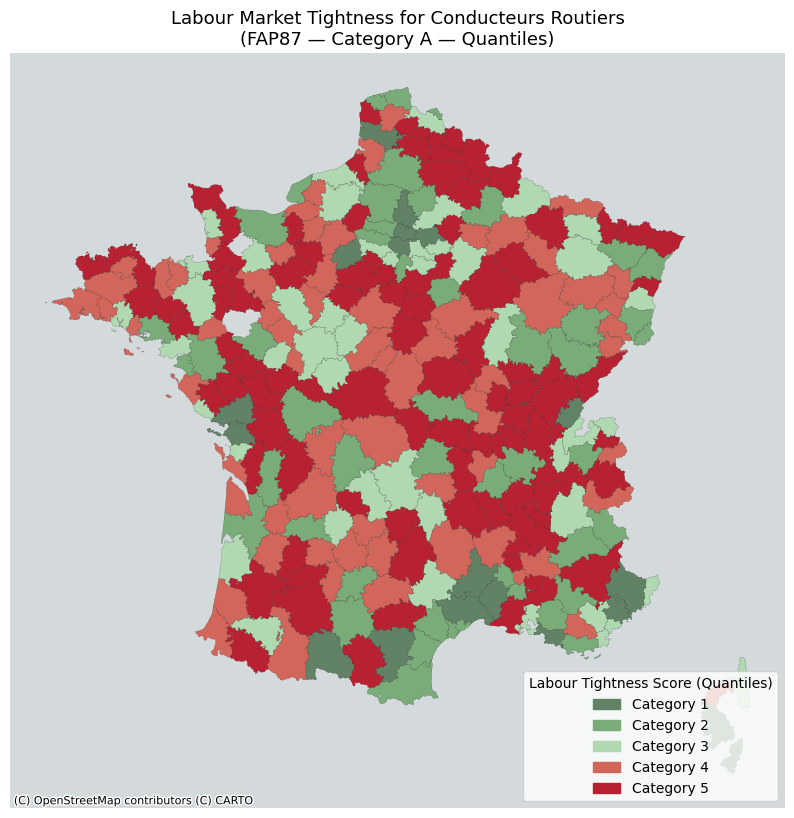

In [159]:
# ---------------------------------------------------
# Filter dataset for a specific FAP87 family (e.g. Conducteurs routiers)
# ---------------------------------------------------
fap_filter = df["famille_pro87"] == "Agents administratifs et commerciaux des transports et du tourisme"
df_map = df[fap_filter].drop_duplicates(subset=["zone_emploi", "fap87"])[["lt_score_a_fap87", "geometry"]]

# ---------------------------------------------------
# Convert to GeoDataFrame with proper CRS and filter out missing geometries
# ---------------------------------------------------
df_map = gpd.GeoDataFrame(df_map, geometry="geometry", crs="EPSG:4326")
df_map = df_map[df_map["geometry"].notna()]  # Drop missing geometries

# ---------------------------------------------------
# Filter geometries within mainland France bounding box
# ---------------------------------------------------
xmin, xmax, ymin, ymax = -5, 10, 41, 52
bounds = df_map.geometry.bounds
df_map = df_map[
    (bounds.minx >= xmin) & (bounds.maxx <= xmax) &
    (bounds.miny >= ymin) & (bounds.maxy <= ymax)
]

# ---------------------------------------------------
# Define a fixed colormap and normalization for lt_score_a_fap87
# ---------------------------------------------------
colors = ["#618264", "#79AC78", "#B0D9B1", "#D2665A", "#B82132"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([1, 2, 3, 4, 5, 6], cmap.N)

# ---------------------------------------------------
# Create the plot
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 12))
df_map.plot(column="lt_score_a_fap87", cmap=cmap, norm=norm, linewidth=0.1,
            edgecolor="black", legend=False, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

legend_patches = [mpatches.Patch(color=colors[i-1], label=f"Category {i}") for i in range(1, 6)]
ax.legend(handles=legend_patches, title="Labour Tightness Score (Quantiles)", loc="lower right", frameon=True)

ax.set_title("Labour Market Tightness for Conducteurs Routiers\n(FAP87 — Category A — Quantiles)", fontsize=13)
ax.set_axis_off()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


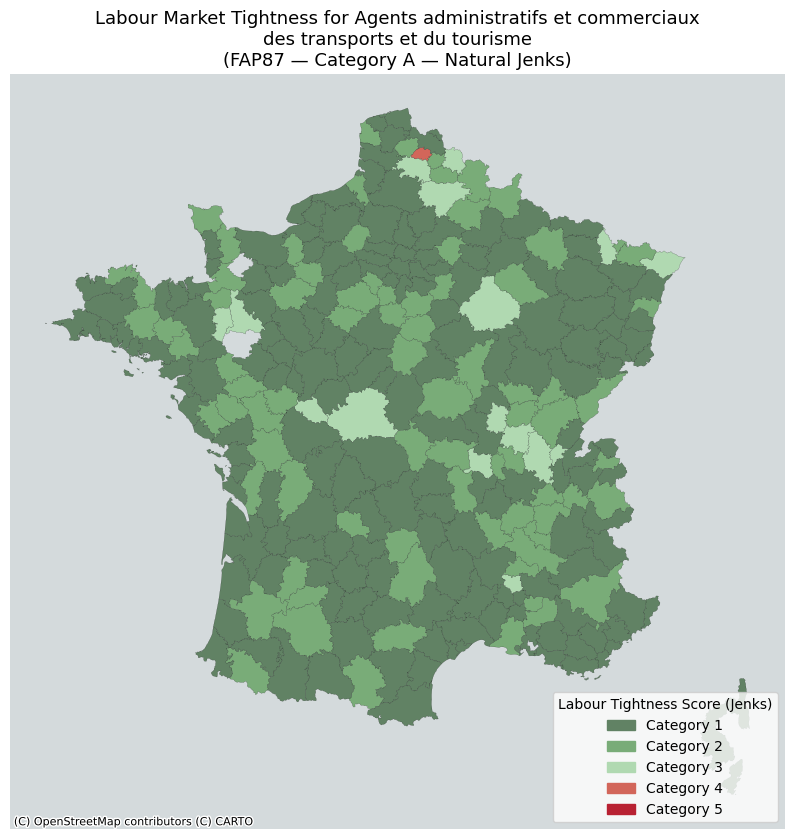

In [160]:
# ---------------------------------------------------
# Filter dataset for a specific FAP87 family
# ---------------------------------------------------
fap_filter = df["famille_pro87"] == "Agents administratifs et commerciaux des transports et du tourisme"
df_map = df[fap_filter].drop_duplicates(subset=["zone_emploi", "fap87"])[["jenks_score_a_fap87", "geometry"]]

# ---------------------------------------------------
# Convert to GeoDataFrame with proper CRS and filter out missing geometries
# ---------------------------------------------------
df_map = gpd.GeoDataFrame(df_map, geometry="geometry", crs="EPSG:4326")
df_map = df_map[df_map["geometry"].notna()]  # Drop missing geometries

# ---------------------------------------------------
# Filter geometries within mainland France bounding box
# ---------------------------------------------------
xmin, xmax, ymin, ymax = -5, 10, 41, 52
bounds = df_map.geometry.bounds
df_map = df_map[
    (bounds.minx >= xmin) & (bounds.maxx <= xmax) &
    (bounds.miny >= ymin) & (bounds.maxy <= ymax)
]

# ---------------------------------------------------
# Define a fixed colormap and normalization for jenks_score_a_fap87
# ---------------------------------------------------
colors = ["#618264", "#79AC78", "#B0D9B1", "#D2665A", "#B82132"]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm([1, 2, 3, 4, 5, 6], cmap.N)

# ---------------------------------------------------
# Create the plot
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 12))
df_map.plot(column="jenks_score_a_fap87", cmap=cmap, norm=norm, linewidth=0.1,
            edgecolor="black", legend=False, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

legend_patches = [mpatches.Patch(color=colors[i-1], label=f"Category {i}") for i in range(1, 6)]
ax.legend(handles=legend_patches, title="Labour Tightness Score (Jenks)", loc="lower right", frameon=True)

ax.set_title("Labour Market Tightness for Agents administratifs et commerciaux\ndes transports et du tourisme\n(FAP87 — Category A — Natural Jenks)", fontsize=13)
ax.set_axis_off()
plt.show()

## 3- EXPORT FILE

In [161]:
# Keep columns of interest
columns_to_keep = [
    "zone_emploi", "month", "job_offers", "jobseekers_a", "jobseekers_abc",
    "famille_pro22", "famille_pro87",
    
    # Ratios and z-scores - FAP87
    "ratio_a_fap87", "ratio_abc_fap87", "ratio_zscore_a_fap87", "ratio_zscore_abc_fap87",
    "lt_score_a_fap87", "lt_score_abc_fap87",

    # Ratios and z-scores - FAP22
    "ratio_a_fap22", "ratio_abc_fap22", "ratio_zscore_a_fap22", "ratio_zscore_abc_fap22",
    "lt_score_a_fap22", "lt_score_abc_fap22",

    # Location
    "departement", "region"
]
df = df[columns_to_keep]

# EXPORT DATASET 
df.to_csv(output_path, index=False)

In [162]:
# Print final dataset
df.head(5)

,zone_emploi,month,job_offers,jobseekers_a,jobseekers_abc,famille_pro22,famille_pro87,ratio_a_fap87,ratio_abc_fap87,ratio_zscore_a_fap87,...,lt_score_a_fap87,lt_score_abc_fap87,ratio_a_fap22,ratio_abc_fap22,ratio_zscore_a_fap22,ratio_zscore_abc_fap22,lt_score_a_fap22,lt_score_abc_fap22,departement,region
0,Abbeville,April,3,10,10,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons",0.3,0.3,-0.329609,...,2,2,0.125000,0.125000,-0.327636,-0.308237,1,1,Somme,Hauts-de-France
1,Abbeville,August,2,10,10,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons",0.2,0.2,-0.340841,...,2,2,0.065138,0.054615,-0.338759,-0.321302,1,1,Somme,Hauts-de-France
2,Abbeville,January,2,10,20,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons",0.2,0.1,-0.340841,...,2,2,0.123457,0.092166,-0.327923,-0.314332,1,1,Somme,Hauts-de-France
3,Abbeville,June,1,10,10,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons",0.1,0.1,-0.352072,...,2,2,0.184000,0.143750,-0.316673,-0.304757,1,1,Somme,Hauts-de-France
4,Abbeville,May,3,10,10,"Agriculture, marine, pêche","Agriculteurs, éleveurs, sylviculteurs, bûcherons",0.3,0.3,-0.329609,...,2,2,0.052586,0.046923,-0.341091,-0.322730,1,1,Somme,Hauts-de-France
